In [1]:
import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits, sigmoid
from keras.datasets import mnist
from nn import nn

2025-09-13 19:55:41.906466: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-13 19:55:41.906941: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-13 19:55:41.964015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-13 19:55:43.664949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## ADAM 

In [2]:
%%time

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 128, 64, 10]

# Random initialization of parameters
params = random_init(layers_dim)
model = nn(params)

# Mini batch
batch_size = 64
m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size

epochs = 30
lr = 1e-2
optimizer = Adam(params, lr)
activations = [relu, relu, relu, relu, relu]

# best config 1e-2 15epoch adam 64bs 99.6%
# 2nd best config 1e-2 15 epoch rmsprop 64bs 99.88%
for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]

    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0 

    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]

        # Forward pass
        Z, cache = model.forward(X_batch, activations)

        # Compute loss
        loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # sum over samples
        epoch_loss += loss * X_batch.shape[0]  
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations)
 
        # Update weights 
        params = optimizer.step(gradients)
        
    # Validation Loop
    for i in range(num_indices_val):
        start = i * batch_size
        end = start + batch_size 

        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = False)
        epoch_loss_val += val_loss * X_val_batch.shape[0]
        
    epoch_loss /= m
    epoch_loss_val /= m
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = False)
    
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.2511, Val Loss: 0.0273, Train Acc: 96.15, Val Acc: 96.22
Epochs: 2, Train Loss: 0.1332, Val Loss: 0.0303, Train Acc: 96.77, Val Acc: 95.85
Epochs: 3, Train Loss: 0.0995, Val Loss: 0.0271, Train Acc: 97.76, Val Acc: 96.52
Epochs: 4, Train Loss: 0.0836, Val Loss: 0.0276, Train Acc: 97.92, Val Acc: 96.60
Epochs: 5, Train Loss: 0.0721, Val Loss: 0.0253, Train Acc: 98.23, Val Acc: 96.93
Epochs: 6, Train Loss: 0.0692, Val Loss: 0.0263, Train Acc: 98.35, Val Acc: 96.83
Epochs: 7, Train Loss: 0.0672, Val Loss: 0.0249, Train Acc: 98.69, Val Acc: 96.95
Epochs: 8, Train Loss: 0.0573, Val Loss: 0.0243, Train Acc: 98.94, Val Acc: 96.87
Epochs: 9, Train Loss: 0.0503, Val Loss: 0.0345, Train Acc: 98.44, Val Acc: 96.79
Epochs: 10, Train Loss: 0.0507, Val Loss: 0.0303, Train Acc: 98.91, Val Acc: 96.71
Epochs: 11, Train Loss: 0.0427, Val Loss: 0.0317, Train Acc: 98.80, Val Acc: 96.95
Epochs: 12, Train Loss: 0.0443, Val Loss: 0.0326, Train Acc: 99.05, Val Acc: 97.07
Epochs: 13, T

## RMSProp

In [3]:
%%time

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 128, 64, 10]

# Random initialization of parameters
params = random_init(layers_dim)
model = nn(params)

# Mini batch
batch_size = 64
m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size

epochs = 30
lr = 1e-2
optimizer = RMSprop(params, lr)
activations = [relu, relu, relu, relu, relu]

# best config 1e-2 15epoch adam 64bs 99.6%
# 2nd best config 1e-2 15 epoch rmsprop 64bs 99.88%
for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]

    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0 

    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]

        # Forward pass
        Z, cache = model.forward(X_batch, activations)

        # Compute loss
        loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # sum over samples
        epoch_loss += loss * X_batch.shape[0]  
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations)
 
        # Update weights 
        params = optimizer.step(gradients)
        
    # Validation Loop
    for i in range(num_indices_val):
        start = i * batch_size
        end = start + batch_size 

        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = False)
        epoch_loss_val += val_loss * X_val_batch.shape[0]
        
    epoch_loss /= m
    epoch_loss_val /= m
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = False)
    
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.2993, Val Loss: 0.0325, Train Acc: 95.36, Val Acc: 95.21
Epochs: 2, Train Loss: 0.1392, Val Loss: 0.0266, Train Acc: 96.91, Val Acc: 96.14
Epochs: 3, Train Loss: 0.1062, Val Loss: 0.0295, Train Acc: 96.67, Val Acc: 95.97
Epochs: 4, Train Loss: 0.0908, Val Loss: 0.0316, Train Acc: 96.77, Val Acc: 95.60
Epochs: 5, Train Loss: 0.0783, Val Loss: 0.0304, Train Acc: 97.83, Val Acc: 96.45
Epochs: 6, Train Loss: 0.0649, Val Loss: 0.0277, Train Acc: 98.41, Val Acc: 96.81
Epochs: 7, Train Loss: 0.0604, Val Loss: 0.0304, Train Acc: 98.36, Val Acc: 96.61
Epochs: 8, Train Loss: 0.0514, Val Loss: 0.0317, Train Acc: 98.93, Val Acc: 96.80
Epochs: 9, Train Loss: 0.0457, Val Loss: 0.0323, Train Acc: 98.76, Val Acc: 97.26
Epochs: 10, Train Loss: 0.0427, Val Loss: 0.0314, Train Acc: 98.93, Val Acc: 97.08
Epochs: 11, Train Loss: 0.0367, Val Loss: 0.0317, Train Acc: 98.96, Val Acc: 96.97
Epochs: 12, Train Loss: 0.0363, Val Loss: 0.0369, Train Acc: 99.04, Val Acc: 96.88
Epochs: 13, T

## SGD

In [4]:
%%time

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 128, 64, 10]

# Random initialization of parameters
params = random_init(layers_dim)
model = nn(params)

# Mini batch
batch_size = 64
m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size

epochs = 30
lr = 1e-1
optimizer = SGD(params, lr)
activations = [relu, relu, relu, relu, relu]

# best config 1e-2 15epoch adam 64bs 99.6%
# 2nd best config 1e-2 15 epoch rmsprop 64bs 99.88%
for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]

    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0 

    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]

        # Forward pass
        Z, cache = model.forward(X_batch, activations)

        # Compute loss
        loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # sum over samples
        epoch_loss += loss * X_batch.shape[0]  
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations)
 
        # Update weights 
        params = optimizer.step(gradients)
        
    # Validation Loop
    for i in range(num_indices_val):
        start = i * batch_size
        end = start + batch_size 

        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = False)
        epoch_loss_val += val_loss * X_val_batch.shape[0]
        
    epoch_loss /= m
    epoch_loss_val /= m
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = False)
    
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 1.8320, Val Loss: 0.2774, Train Acc: 71.01, Val Acc: 72.95
Epochs: 2, Train Loss: 1.0633, Val Loss: 0.1658, Train Acc: 79.95, Val Acc: 82.29
Epochs: 3, Train Loss: 0.7308, Val Loss: 0.1241, Train Acc: 83.65, Val Acc: 85.60
Epochs: 4, Train Loss: 0.5883, Val Loss: 0.1036, Train Acc: 85.79, Val Acc: 87.26
Epochs: 5, Train Loss: 0.5098, Val Loss: 0.0916, Train Acc: 87.02, Val Acc: 88.38
Epochs: 6, Train Loss: 0.4601, Val Loss: 0.0838, Train Acc: 87.99, Val Acc: 89.17
Epochs: 7, Train Loss: 0.4255, Val Loss: 0.0782, Train Acc: 88.66, Val Acc: 89.78
Epochs: 8, Train Loss: 0.3999, Val Loss: 0.0739, Train Acc: 89.14, Val Acc: 90.15
Epochs: 9, Train Loss: 0.3801, Val Loss: 0.0707, Train Acc: 89.56, Val Acc: 90.58
Epochs: 10, Train Loss: 0.3644, Val Loss: 0.0681, Train Acc: 89.90, Val Acc: 90.71
Epochs: 11, Train Loss: 0.3510, Val Loss: 0.0659, Train Acc: 90.17, Val Acc: 91.17
Epochs: 12, Train Loss: 0.3400, Val Loss: 0.0641, Train Acc: 90.46, Val Acc: 91.30
Epochs: 13, T

## SGD w/Momentum

In [5]:
%%time
# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim)
model = nn(params)

# Mini batch
batch_size = 64
m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size

epochs = 30
lr = 1e-1
optimizer = SGD(params, lr, beta = 0.8, momentum = True)
activations = [relu, relu, relu, relu, relu]

# best config 1e-2 15epoch adam 64bs 99.6%
# 2nd best config 1e-2 15 epoch rmsprop 64bs 99.88%
for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]

    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0 

    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]

        # Forward pass
        Z, cache = model.forward(X_batch, activations)

        # Compute loss
        loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # sum over samples
        epoch_loss += loss * X_batch.shape[0]  
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations)
 
        # Update weights 
        params = optimizer.step(gradients)
        
    # Validation Loop
    for i in range(num_indices_val):
        start = i * batch_size
        end = start + batch_size 

        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = False)
        epoch_loss_val += val_loss * X_val_batch.shape[0]
        
    epoch_loss /= m
    epoch_loss_val /= m
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = False)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = False)
    
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 2.1002, Val Loss: 0.3768, Train Acc: 41.90, Val Acc: 42.62
Epochs: 2, Train Loss: 1.6281, Val Loss: 0.2833, Train Acc: 60.91, Val Acc: 62.43
Epochs: 3, Train Loss: 1.1877, Val Loss: 0.1983, Train Acc: 73.41, Val Acc: 75.69
Epochs: 4, Train Loss: 0.8807, Val Loss: 0.1508, Train Acc: 78.95, Val Acc: 81.17
Epochs: 5, Train Loss: 0.7120, Val Loss: 0.1252, Train Acc: 81.86, Val Acc: 83.71
Epochs: 6, Train Loss: 0.6140, Val Loss: 0.1098, Train Acc: 83.77, Val Acc: 85.32
Epochs: 7, Train Loss: 0.5507, Val Loss: 0.0996, Train Acc: 85.22, Val Acc: 86.68
Epochs: 8, Train Loss: 0.5062, Val Loss: 0.0923, Train Acc: 86.21, Val Acc: 87.36
Epochs: 9, Train Loss: 0.4734, Val Loss: 0.0868, Train Acc: 86.96, Val Acc: 87.98
Epochs: 10, Train Loss: 0.4478, Val Loss: 0.0825, Train Acc: 87.64, Val Acc: 88.68
Epochs: 11, Train Loss: 0.4272, Val Loss: 0.0792, Train Acc: 88.00, Val Acc: 89.02
Epochs: 12, Train Loss: 0.4106, Val Loss: 0.0763, Train Acc: 88.42, Val Acc: 89.46
Epochs: 13, T

# Batch Normalization

## Adam

In [6]:
%%time

import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits
from keras.datasets import mnist
from nn import nn

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim, batch_norm = True)

model = nn(params) 
activations = [relu, relu, relu, relu]
# Mini batch
batch_size = 64

m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size
epochs = 30
lr = 1e-2

# Optimizer
optimizer = Adam(params, lr, batch_norm = True)

for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]
    
    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]
        
        # Forward pass
        Z, cache = model.forward(X = X_batch, activations = activations, batch_norm = True, verbose = False)

        # Compute loss
        train_loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # train loss
        epoch_loss += train_loss * X_batch.shape[0]
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations, batch_norm = True)
 
        # Update weights
        params = optimizer.step(gradients)
    # Validation loop
    for i in range(num_indices_val):
        start = i * batch_size
        end =  start + batch_size
        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        # val loss
        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = True)
        epoch_loss_val += val_loss 
        
    epoch_loss /= m
    epoch_loss_val /= m_val
    
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = True)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = True)
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.3103, Val Loss: 0.0026, Train Acc: 95.08, Val Acc: 95.07
Epochs: 2, Train Loss: 0.1677, Val Loss: 0.0023, Train Acc: 96.40, Val Acc: 95.78
Epochs: 3, Train Loss: 0.1400, Val Loss: 0.0019, Train Acc: 97.32, Val Acc: 96.40
Epochs: 4, Train Loss: 0.1227, Val Loss: 0.0019, Train Acc: 97.50, Val Acc: 96.48
Epochs: 5, Train Loss: 0.1128, Val Loss: 0.0018, Train Acc: 97.64, Val Acc: 96.60
Epochs: 6, Train Loss: 0.1051, Val Loss: 0.0017, Train Acc: 97.99, Val Acc: 96.92
Epochs: 7, Train Loss: 0.0982, Val Loss: 0.0018, Train Acc: 98.00, Val Acc: 96.75
Epochs: 8, Train Loss: 0.0907, Val Loss: 0.0016, Train Acc: 98.33, Val Acc: 97.17
Epochs: 9, Train Loss: 0.0893, Val Loss: 0.0017, Train Acc: 98.38, Val Acc: 97.01
Epochs: 10, Train Loss: 0.0851, Val Loss: 0.0018, Train Acc: 98.32, Val Acc: 96.76
Epochs: 11, Train Loss: 0.0804, Val Loss: 0.0016, Train Acc: 98.57, Val Acc: 97.08
Epochs: 12, Train Loss: 0.0762, Val Loss: 0.0016, Train Acc: 98.71, Val Acc: 97.26
Epochs: 13, T

## RMSprop

In [7]:
%%time

import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits
from keras.datasets import mnist
from nn import nn

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim, batch_norm = True)

model = nn(params) 
activations = [relu, relu, relu, relu]
# Mini batch
batch_size = 64

m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size
epochs = 30
lr = 1e-2

# Optimizer
optimizer = RMSprop(params, lr, batch_norm = True)

for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]
    
    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]
        
        # Forward pass
        Z, cache = model.forward(X = X_batch, activations = activations, batch_norm = True, verbose = False)

        # Compute loss
        train_loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # train loss
        epoch_loss += train_loss * X_batch.shape[0]
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations, batch_norm = True)
 
        # Update weights
        params = optimizer.step(gradients)
    # Validation loop
    for i in range(num_indices_val):
        start = i * batch_size
        end =  start + batch_size
        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        # val loss
        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = True)
        epoch_loss_val += val_loss 
        
    epoch_loss /= m
    epoch_loss_val /= m_val
    
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = True)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = True)
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 0.3925, Val Loss: 0.0033, Train Acc: 94.15, Val Acc: 94.15
Epochs: 2, Train Loss: 0.1997, Val Loss: 0.0025, Train Acc: 96.04, Val Acc: 95.65
Epochs: 3, Train Loss: 0.1613, Val Loss: 0.0022, Train Acc: 96.94, Val Acc: 96.18
Epochs: 4, Train Loss: 0.1415, Val Loss: 0.0022, Train Acc: 97.18, Val Acc: 96.23
Epochs: 5, Train Loss: 0.1315, Val Loss: 0.0021, Train Acc: 97.54, Val Acc: 96.49
Epochs: 6, Train Loss: 0.1186, Val Loss: 0.0019, Train Acc: 97.73, Val Acc: 96.75
Epochs: 7, Train Loss: 0.1110, Val Loss: 0.0020, Train Acc: 97.74, Val Acc: 96.54
Epochs: 8, Train Loss: 0.1030, Val Loss: 0.0019, Train Acc: 97.91, Val Acc: 96.60
Epochs: 9, Train Loss: 0.1026, Val Loss: 0.0019, Train Acc: 98.16, Val Acc: 96.84
Epochs: 10, Train Loss: 0.0979, Val Loss: 0.0019, Train Acc: 98.11, Val Acc: 96.74
Epochs: 11, Train Loss: 0.0924, Val Loss: 0.0018, Train Acc: 98.49, Val Acc: 97.11
Epochs: 12, Train Loss: 0.0909, Val Loss: 0.0018, Train Acc: 98.40, Val Acc: 97.02
Epochs: 13, T

## SGD

In [8]:
%%time

import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits
from keras.datasets import mnist
from nn import nn

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim, batch_norm = True)

model = nn(params) 
activations = [relu, relu, relu, relu]
# Mini batch
batch_size = 64

m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size
epochs = 30
lr = 1e-1

# Optimizer
optimizer = SGD(params, lr, batch_norm = True)

for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]
    
    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]
        
        # Forward pass
        Z, cache = model.forward(X = X_batch, activations = activations, batch_norm = True, verbose = False)

        # Compute loss
        train_loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # train loss
        epoch_loss += train_loss * X_batch.shape[0]
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations, batch_norm = True)
 
        # Update weights
        params = optimizer.step(gradients)
    # Validation loop
    for i in range(num_indices_val):
        start = i * batch_size
        end =  start + batch_size
        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        # val loss
        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = True)
        epoch_loss_val += val_loss 
        
    epoch_loss /= m
    epoch_loss_val /= m_val
    
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = True)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = True)
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 1.7708, Val Loss: 0.0191, Train Acc: 58.91, Val Acc: 60.33
Epochs: 2, Train Loss: 1.0719, Val Loss: 0.0125, Train Acc: 74.42, Val Acc: 76.26
Epochs: 3, Train Loss: 0.7731, Val Loss: 0.0092, Train Acc: 82.32, Val Acc: 84.16
Epochs: 4, Train Loss: 0.6198, Val Loss: 0.0077, Train Acc: 85.30, Val Acc: 86.41
Epochs: 5, Train Loss: 0.5437, Val Loss: 0.0067, Train Acc: 86.88, Val Acc: 88.10
Epochs: 6, Train Loss: 0.4914, Val Loss: 0.0062, Train Acc: 87.93, Val Acc: 88.98
Epochs: 7, Train Loss: 0.4558, Val Loss: 0.0058, Train Acc: 88.73, Val Acc: 89.59
Epochs: 8, Train Loss: 0.4252, Val Loss: 0.0055, Train Acc: 89.41, Val Acc: 90.31
Epochs: 9, Train Loss: 0.4110, Val Loss: 0.0053, Train Acc: 89.88, Val Acc: 90.54
Epochs: 10, Train Loss: 0.3924, Val Loss: 0.0051, Train Acc: 90.15, Val Acc: 90.79
Epochs: 11, Train Loss: 0.3775, Val Loss: 0.0048, Train Acc: 90.69, Val Acc: 91.22
Epochs: 12, Train Loss: 0.3637, Val Loss: 0.0047, Train Acc: 90.94, Val Acc: 91.50
Epochs: 13, T

## SGD w/Momentum

In [9]:
%%time

import numpy as np
from utils import random_init, compute_validation_loss
from optim.SGD import SGD
from optim.Adam import Adam
from optim.RMSprop import RMSprop
from activation_func.activations import relu, cross_entropy_from_logits
from keras.datasets import mnist
from nn import nn

# Load and preprocess data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Making a validation set
X_val = X_train[-10240:,]
y_val = y_train[-10240:]

X_train = X_train[:-10240]
y_train = y_train[:-10240]

# Normalize and reshape
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Parameters
layers_dim = [784, 32, 16, 10]

# Random initialization of parameters
params = random_init(layers_dim, batch_norm = True)

model = nn(params) 
activations = [relu, relu, relu, relu]
# Mini batch
batch_size = 64

m = X_train.shape[0]
m_val = X_val.shape[0]

num_indices = m // batch_size
num_indices_val = m_val // batch_size
epochs = 30
lr = 1e-1

# Optimizer
optimizer = SGD(params, lr, beta = 0.8, momentum = True, batch_norm = True)

for epoch in range(epochs):
    # Shuffle on each epoch
    perm = np.random.permutation(m)
    X_shuffled = X_train[perm, :]
    y_shuffled = y_train[perm,]
    
    perm_val = np.random.permutation(m_val)
    X_val_shuffled = X_val[perm_val, :]
    y_val_shuffled = y_val[perm_val,]
    
    epoch_loss = 0.0
    epoch_loss_val = 0.0
    # Training Loop
    for i in range(num_indices):
        start = i * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end, :]
        y_batch = y_shuffled[start:end,]
        
        # Forward pass
        Z, cache = model.forward(X = X_batch, activations = activations, batch_norm = True, verbose = False)

        # Compute loss
        train_loss, dZ3 = cross_entropy_from_logits(Z, y_batch)
        
        # train loss
        epoch_loss += train_loss * X_batch.shape[0]
        
        # Backward pass
        gradients = model.backward(y_batch, dZ3, cache, activations, batch_norm = True)
 
        # Update weights
        params = optimizer.step(gradients)
    # Validation loop
    for i in range(num_indices_val):
        start = i * batch_size
        end =  start + batch_size
        X_val_batch = X_val_shuffled[start:end, :]
        y_val_batch = y_val_shuffled[start:end,]

        # val loss
        val_loss = compute_validation_loss(model, X_val_batch, y_val_batch, activations, batch_norm = True)
        epoch_loss_val += val_loss 
        
    epoch_loss /= m
    epoch_loss_val /= m_val
    
    train_acc = model.accuracy(X_train, y_train, activations, batch_norm = True)
    val_acc = model.accuracy(X_val, y_val, activations, batch_norm = True)
    print(f"Epochs: {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_loss_val:.4f}, Train Acc: {train_acc * 100:.2f}, Val Acc: {val_acc * 100:.2f}")


Epochs: 1, Train Loss: 1.7817, Val Loss: 0.0193, Train Acc: 58.53, Val Acc: 60.00
Epochs: 2, Train Loss: 1.0761, Val Loss: 0.0126, Train Acc: 74.26, Val Acc: 76.11
Epochs: 3, Train Loss: 0.7743, Val Loss: 0.0092, Train Acc: 82.27, Val Acc: 84.07
Epochs: 4, Train Loss: 0.6202, Val Loss: 0.0077, Train Acc: 85.24, Val Acc: 86.49
Epochs: 5, Train Loss: 0.5435, Val Loss: 0.0068, Train Acc: 86.84, Val Acc: 88.14
Epochs: 6, Train Loss: 0.4912, Val Loss: 0.0062, Train Acc: 87.89, Val Acc: 88.92
Epochs: 7, Train Loss: 0.4556, Val Loss: 0.0058, Train Acc: 88.75, Val Acc: 89.60
Epochs: 8, Train Loss: 0.4251, Val Loss: 0.0055, Train Acc: 89.41, Val Acc: 90.28
Epochs: 9, Train Loss: 0.4108, Val Loss: 0.0053, Train Acc: 89.85, Val Acc: 90.52
Epochs: 10, Train Loss: 0.3923, Val Loss: 0.0051, Train Acc: 90.19, Val Acc: 90.83
Epochs: 11, Train Loss: 0.3773, Val Loss: 0.0048, Train Acc: 90.70, Val Acc: 91.24
Epochs: 12, Train Loss: 0.3637, Val Loss: 0.0047, Train Acc: 90.94, Val Acc: 91.51
Epochs: 13, T

## Generated Plots

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_training_logs(text):
    """Parse the training logs from the text file"""
    data = {
        'no_bn': {'Adam': {}, 'RMSprop': {}, 'SGD': {}},
        'with_bn': {'Adam': {}, 'RMSprop': {}, 'SGD': {}}
    }
    
    lines = text.strip().split('\n')
    current_section = None
    current_optimizer = None
    
    for line in lines:
        # Check for section headers
        if 'No Batch Norm' in line:
            current_section = 'no_bn'
            continue
        elif 'with batchnorm' in line:
            current_section = 'with_bn'
            continue
        elif line.strip() in ['Adam', 'RMSprop', 'SGD']:
            current_optimizer = line.strip()
            for metric in ['train_loss', 'val_loss', 'train_acc', 'val_acc']:
                data[current_section][current_optimizer][metric] = []
            continue
        
        # Parse epoch data
        if 'Epochs:' in line and current_section and current_optimizer:
            match = re.search(r'Epochs: (\d+), Train Loss: ([\d.]+), Val Loss: ([\d.]+), Train Acc: ([\d.]+), Val Acc: ([\d.]+)', line)
            if match:
                epoch, train_loss, val_loss, train_acc, val_acc = match.groups()
                data[current_section][current_optimizer]['train_loss'].append(float(train_loss))
                data[current_section][current_optimizer]['val_loss'].append(float(val_loss))
                data[current_section][current_optimizer]['train_acc'].append(float(train_acc))
                data[current_section][current_optimizer]['val_acc'].append(float(val_acc))
    
    return data

def create_comparison_plots(data, prefix="xyz"):
    """Create comprehensive comparison plots and save them as images"""
    import matplotlib.pyplot as plt
    import numpy as np

    # Style
    plt.style.use('seaborn-v0_8-darkgrid')

    # Colors
    colors = {
        'Adam': {'no_bn': '#FF6B6B', 'with_bn': '#4ECDC4'},
        'RMSprop': {'no_bn': '#95E77E', 'with_bn': '#45B7D1'},
        'SGD': {'no_bn': '#FFA07A', 'with_bn': '#98D8C8'}
    }

    epochs = np.arange(1, 31)

    # =========================
    # FIGURE 1 – OVERVIEW PLOTS
    # =========================
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('Batch Normalization Impact on Training Performance',
                 fontsize=20, fontweight='bold', y=1.02)

    # Training Loss
    ax1 = plt.subplot(2, 3, 1)
    for optimizer in ['Adam', 'RMSprop', 'SGD']:
        ax1.plot(epochs, data['no_bn'][optimizer]['train_loss'],
                 linestyle='--', linewidth=2, alpha=0.7,
                 color=colors[optimizer]['no_bn'],
                 label=f'{optimizer} (No BN)')
        ax1.plot(epochs, data['with_bn'][optimizer]['train_loss'],
                 linestyle='-', linewidth=2,
                 color=colors[optimizer]['with_bn'],
                 label=f'{optimizer} (With BN)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Training Loss Comparison')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)

    # Validation Loss
    ax2 = plt.subplot(2, 3, 2)
    for optimizer in ['Adam', 'RMSprop', 'SGD']:
        ax2.plot(epochs, data['no_bn'][optimizer]['val_loss'], '--',
                 linewidth=2, alpha=0.7,
                 color=colors[optimizer]['no_bn'],
                 label=f'{optimizer} (No BN)')
        ax2.plot(epochs, data['with_bn'][optimizer]['val_loss'], '-',
                 linewidth=2,
                 color=colors[optimizer]['with_bn'],
                 label=f'{optimizer} (With BN)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Validation Loss Comparison')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0, top=0.1)

    # Training Accuracy
    ax3 = plt.subplot(2, 3, 4)
    for optimizer in ['Adam', 'RMSprop', 'SGD']:
        ax3.plot(epochs, data['no_bn'][optimizer]['train_acc'], '--',
                 linewidth=2, alpha=0.7,
                 color=colors[optimizer]['no_bn'],
                 label=f'{optimizer} (No BN)')
        ax3.plot(epochs, data['with_bn'][optimizer]['train_acc'], '-',
                 linewidth=2,
                 color=colors[optimizer]['with_bn'],
                 label=f'{optimizer} (With BN)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Training Accuracy (%)')
    ax3.set_title('Training Accuracy Comparison')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(50, 100)

    # Validation Accuracy
    ax4 = plt.subplot(2, 3, 5)
    for optimizer in ['Adam', 'RMSprop', 'SGD']:
        ax4.plot(epochs, data['no_bn'][optimizer]['val_acc'], '--',
                 linewidth=2, alpha=0.7,
                 color=colors[optimizer]['no_bn'],
                 label=f'{optimizer} (No BN)')
        ax4.plot(epochs, data['with_bn'][optimizer]['val_acc'], '-',
                 linewidth=2,
                 color=colors[optimizer]['with_bn'],
                 label=f'{optimizer} (With BN)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy (%)')
    ax4.set_title('Validation Accuracy Comparison')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(50, 100)

    # Final Validation Accuracy
    ax5 = plt.subplot(2, 3, (3, 6))
    final_val_acc = []
    labels = []
    bar_colors = []
    positions = []
    x_pos = 0
    for optimizer in ['Adam', 'RMSprop', 'SGD']:
        final_val_acc.append(data['no_bn'][optimizer]['val_acc'][-1])
        labels.append(f'{optimizer}\n(No BN)')
        bar_colors.append(colors[optimizer]['no_bn'])
        positions.append(x_pos)
        x_pos += 1

        final_val_acc.append(data['with_bn'][optimizer]['val_acc'][-1])
        labels.append(f'{optimizer}\n(With BN)')
        bar_colors.append(colors[optimizer]['with_bn'])
        positions.append(x_pos)
        x_pos += 1.5

    bars = ax5.bar(positions, final_val_acc, color=bar_colors,
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax5.set_ylabel('Final Validation Accuracy (%)')
    ax5.set_title('Final Validation Accuracy Comparison (Epoch 30)')
    ax5.set_xticks(positions)
    ax5.set_xticklabels(labels, fontsize=9)
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.set_ylim(90, 98)

    for bar, val in zip(bars, final_val_acc):
        ax5.text(bar.get_x() + bar.get_width()/2., val + 0.1,
                 f'{val:.2f}%', ha='center', va='bottom',
                 fontsize=9, fontweight='bold')

    plt.tight_layout()
    fig.savefig(f"{prefix}_overview.png", dpi=300,
                bbox_inches="tight", facecolor="white")
    plt.show()

    # =========================
    # FIGURE 2 – DETAILED PLOTS
    # =========================
    fig2, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig2.suptitle('Detailed Optimizer-wise Comparison',
                  fontsize=20, fontweight='bold', y=1.02)

    for idx, optimizer in enumerate(['Adam', 'RMSprop', 'SGD']):
        # Training Loss
        axes[idx, 0].plot(epochs, data['no_bn'][optimizer]['train_loss'],
                          'o-', linewidth=2, markersize=4, alpha=0.7,
                          color=colors[optimizer]['no_bn'], label='No BN')
        axes[idx, 0].plot(epochs, data['with_bn'][optimizer]['train_loss'],
                          's-', linewidth=2, markersize=4,
                          color=colors[optimizer]['with_bn'], label='With BN')
        axes[idx, 0].set_title(f'{optimizer} - Training Loss')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Loss')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)

        # Validation Loss
        axes[idx, 1].plot(epochs, data['no_bn'][optimizer]['val_loss'],
                          'o-', linewidth=2, markersize=4, alpha=0.7,
                          color=colors[optimizer]['no_bn'], label='No BN')
        axes[idx, 1].plot(epochs, data['with_bn'][optimizer]['val_loss'],
                          's-', linewidth=2, markersize=4,
                          color=colors[optimizer]['with_bn'], label='With BN')
        axes[idx, 1].set_title(f'{optimizer} - Validation Loss')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)

        # Training Accuracy
        axes[idx, 2].plot(epochs, data['no_bn'][optimizer]['train_acc'],
                          'o-', linewidth=2, markersize=4, alpha=0.7,
                          color=colors[optimizer]['no_bn'], label='No BN')
        axes[idx, 2].plot(epochs, data['with_bn'][optimizer]['train_acc'],
                          's-', linewidth=2, markersize=4,
                          color=colors[optimizer]['with_bn'], label='With BN')
        axes[idx, 2].set_title(f'{optimizer} - Training Accuracy')
        axes[idx, 2].set_xlabel('Epoch')
        axes[idx, 2].set_ylabel('Accuracy (%)')
        axes[idx, 2].legend()
        axes[idx, 2].grid(True, alpha=0.3)
        axes[idx, 2].set_ylim(50, 100)

        # Validation Accuracy
        axes[idx, 3].plot(epochs, data['no_bn'][optimizer]['val_acc'],
                          'o-', linewidth=2, markersize=4, alpha=0.7,
                          color=colors[optimizer]['no_bn'], label='No BN')
        axes[idx, 3].plot(epochs, data['with_bn'][optimizer]['val_acc'],
                          's-', linewidth=2, markersize=4,
                          color=colors[optimizer]['with_bn'], label='With BN')
        axes[idx, 3].set_title(f'{optimizer} - Validation Accuracy')
        axes[idx, 3].set_xlabel('Epoch')
        axes[idx, 3].set_ylabel('Accuracy (%)')
        axes[idx, 3].legend()
        axes[idx, 3].grid(True, alpha=0.3)
        axes[idx, 3].set_ylim(50, 100)

    plt.tight_layout()
    fig2.savefig(f"{prefix}_optimizer_detailed.png", dpi=300,
                 bbox_inches="tight", facecolor="white")
    plt.show()

    # =========================
    # FIGURE 3 – CONVERGENCE PLOTS
    # =========================
    fig3, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig3.suptitle('Convergence Speed Analysis (Epochs to reach 95% Val Accuracy)',
                  fontsize=16, fontweight='bold', y=1.05)

    for idx, optimizer in enumerate(['Adam', 'RMSprop', 'SGD']):
        no_bn_95 = next((i+1 for i, acc in enumerate(data['no_bn'][optimizer]['val_acc'])
                         if acc >= 95), 30)
        with_bn_95 = next((i+1 for i, acc in enumerate(data['with_bn'][optimizer]['val_acc'])
                          if acc >= 95), 30)

        bars = axes[idx].bar(['No BN', 'With BN'], [no_bn_95, with_bn_95],
                             color=[colors[optimizer]['no_bn'], colors[optimizer]['with_bn']],
                             alpha=0.8, edgecolor='black', linewidth=2)
        axes[idx].set_title(f'{optimizer}')
        axes[idx].set_ylabel('Epochs to 95% Val Accuracy')
        axes[idx].set_ylim(0, 35)
        axes[idx].grid(True, alpha=0.3, axis='y')

        for bar, val in zip(bars, [no_bn_95, with_bn_95]):
            axes[idx].text(bar.get_x() + bar.get_width()/2., val + 0.5,
                           f'{val}', ha='center', va='bottom',
                           fontsize=12, fontweight='bold')

    plt.tight_layout()
    fig3.savefig(f"{prefix}_convergence.png", dpi=300,
                 bbox_inches="tight", facecolor="white")
    plt.show()


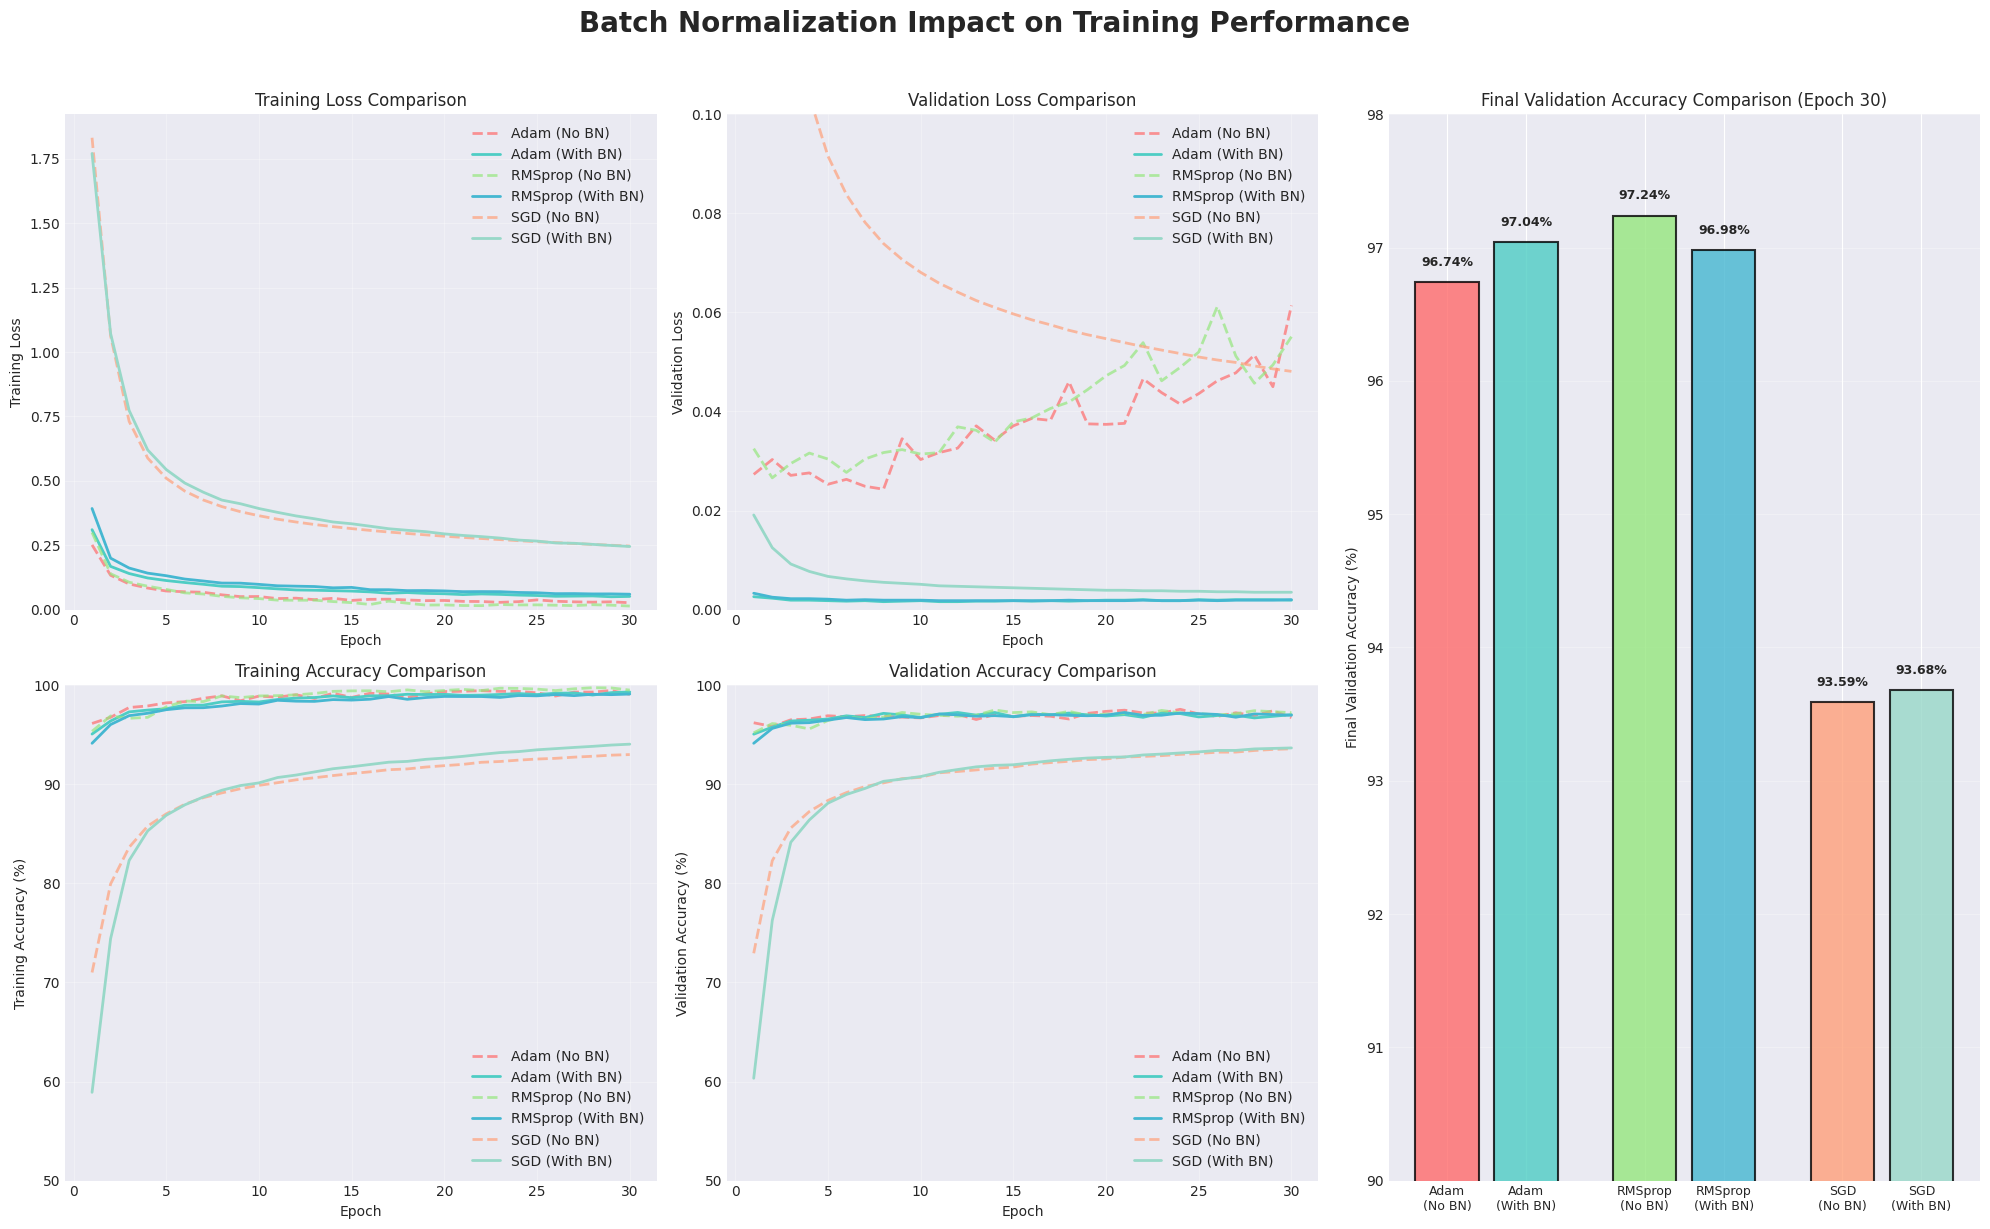

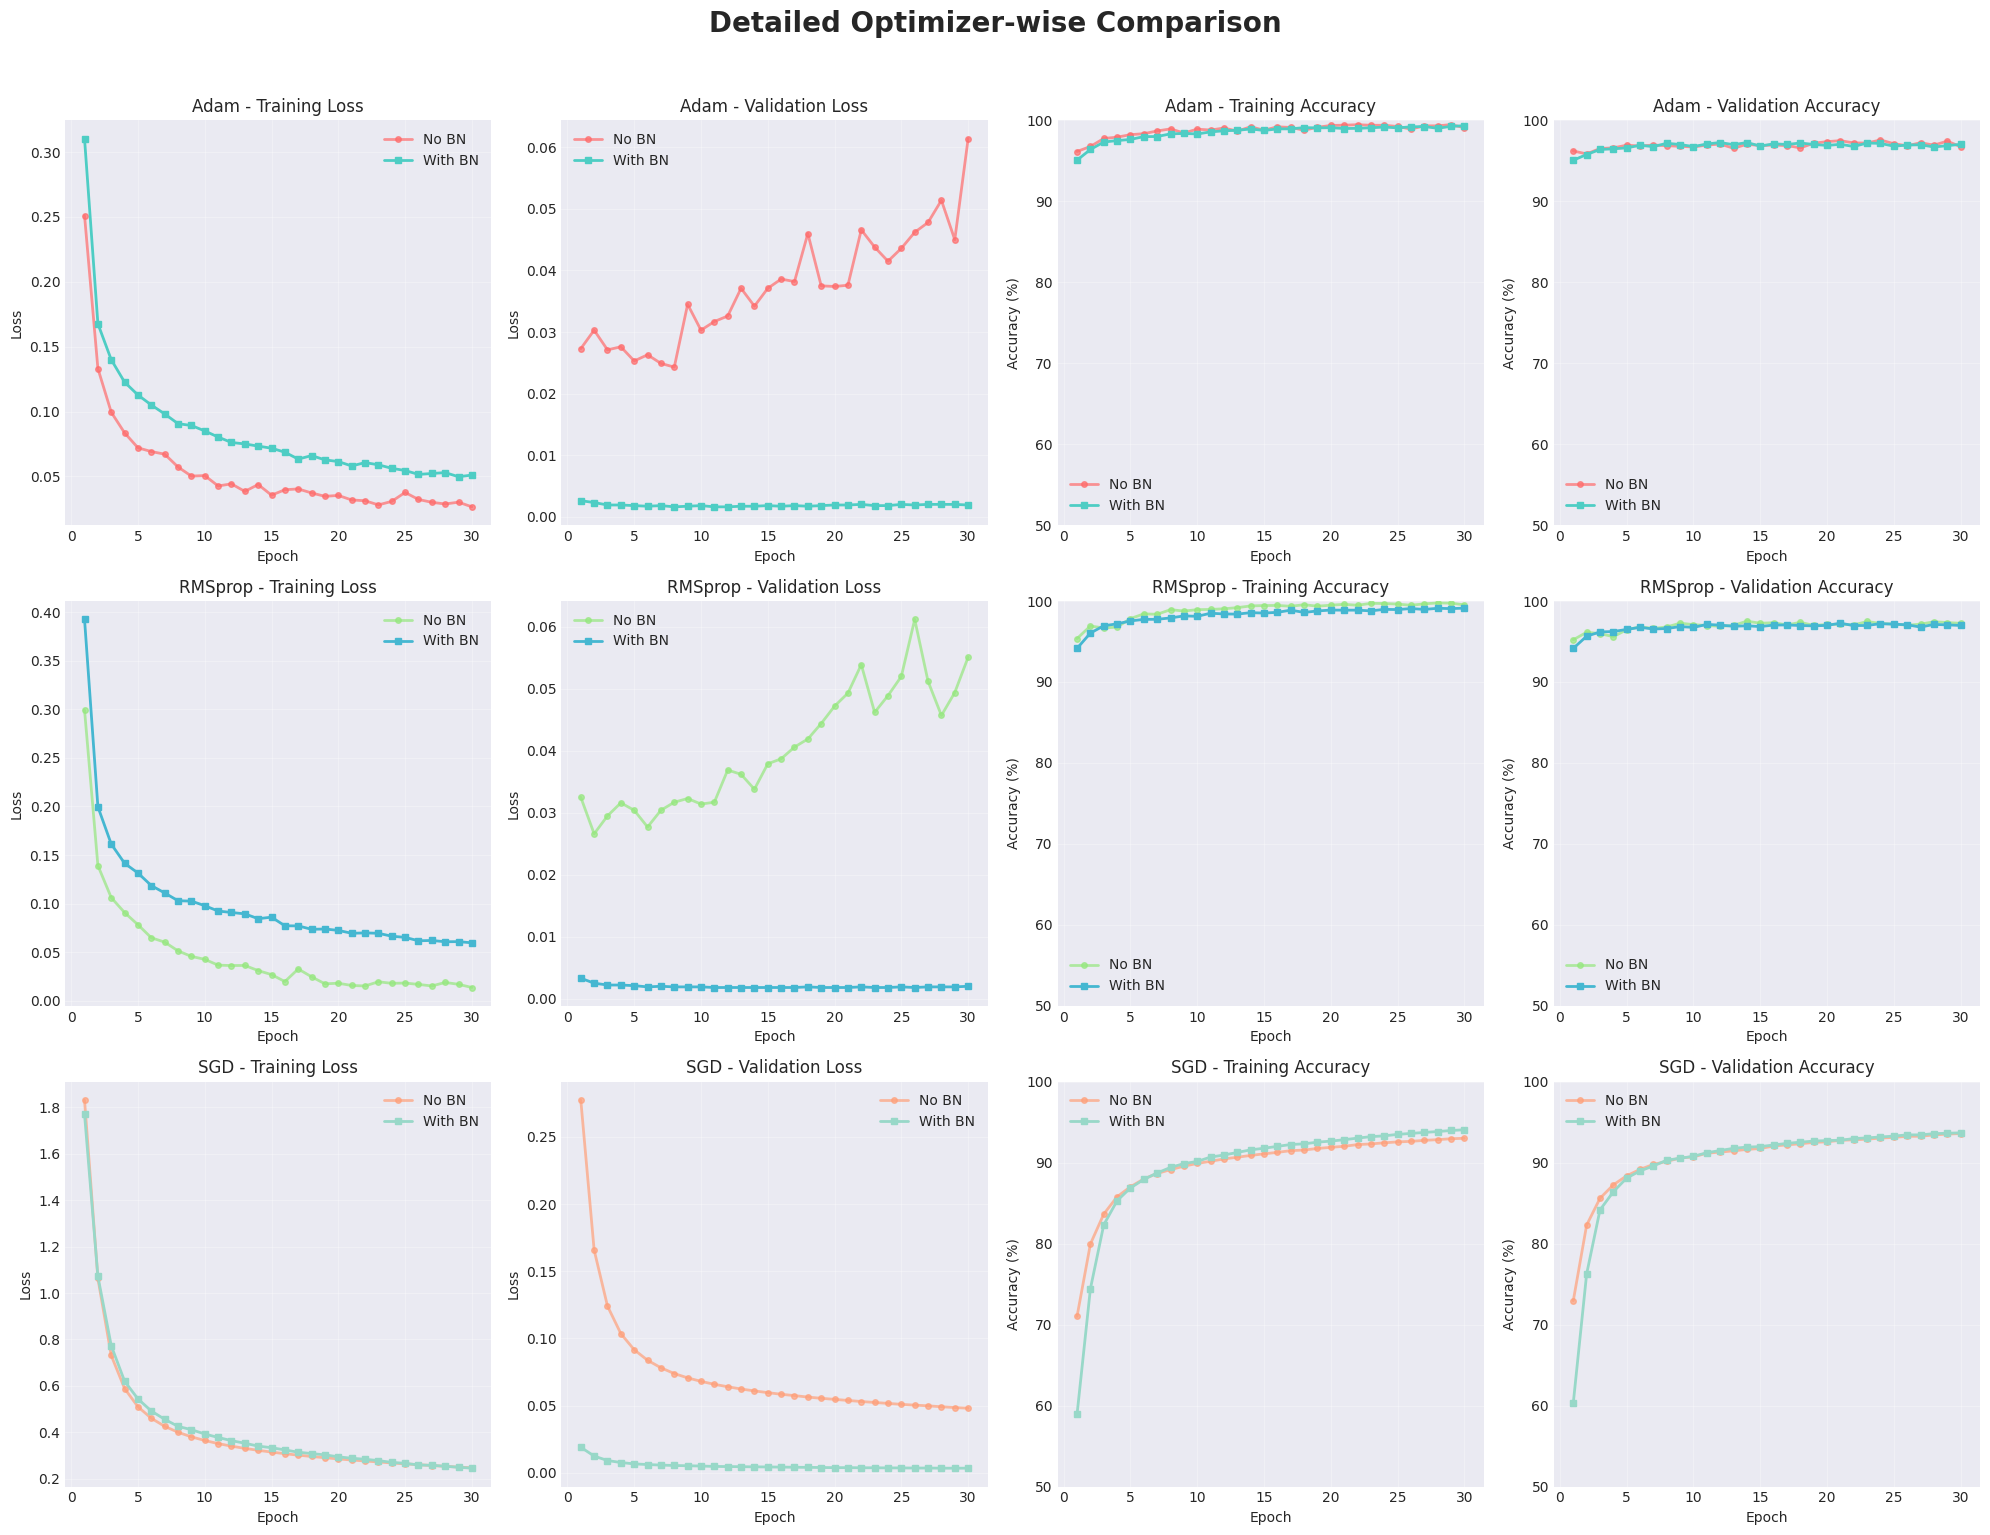

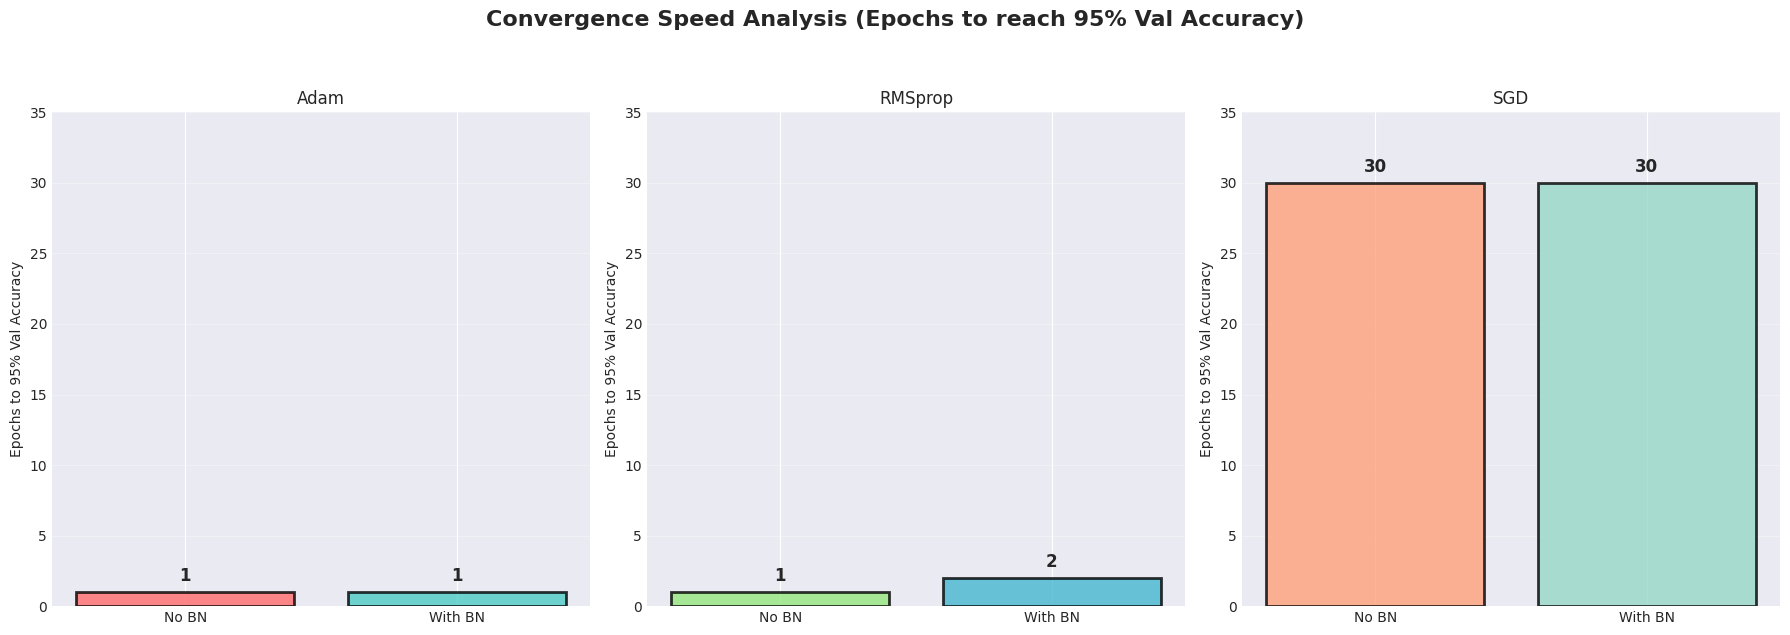

<Figure size 640x480 with 0 Axes>

In [6]:
#Usage example:
if __name__ == "__main__":
    # Read the text file
    with open('here', 'r') as f:
        text = f.read()
    
    # Parse the data
    data = parse_training_logs(text)
    
    # Create the plots
    create_comparison_plots(data)

    # Optional: Save figures instead of showing
    plt.savefig('batch_norm_comparison1.png', dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_time(time_str):
    """Parse time string like '1min 44s' or '37.2 s' to seconds"""
    if 'min' in time_str:
        parts = re.findall(r'(\d+(?:\.\d+)?)', time_str)
        if len(parts) == 2:
            return float(parts[0]) * 60 + float(parts[1])
        else:
            return float(parts[0]) * 60
    else:
        return float(re.findall(r'(\d+(?:\.\d+)?)', time_str)[0])

# Read the data from file
with open('here1', 'r') as f:
    content = f.read()

# Parse the data
lines = content.strip().split('\n')
optimizers = ['Adam', 'RMSprop', 'SGD']
no_batchnorm_times = []
with_batchnorm_times = []

# Extract times for each optimizer
i = 0
while i < len(lines):
    line = lines[i].strip()
    if line == "No batchnorm":
        i += 1
        for opt in optimizers:
            while i < len(lines) and not lines[i].strip().startswith(opt):
                i += 1
            if i < len(lines):
                i += 1  # Move to wall time line
                if i < len(lines):
                    time_str = lines[i].strip().replace('Wall time: ', '')
                    no_batchnorm_times.append(parse_time(time_str))
                    i += 1
    elif line == "with Batchnorm":
        i += 1
        for opt in optimizers:
            while i < len(lines) and not lines[i].strip().startswith(opt):
                i += 1
            if i < len(lines):
                i += 1  # Move to wall time line
                if i < len(lines):
                    time_str = lines[i].strip().replace('Wall time: ', '')
                    with_batchnorm_times.append(parse_time(time_str))
                    i += 1
    else:
        i += 1

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(optimizers))
width = 0.35

bars1 = ax.bar(x - width/2, no_batchnorm_times, width, label='No BatchNorm', 
               color='#ff6b6b', alpha=0.8, edgecolor='darkred', linewidth=1.5)
bars2 = ax.bar(x + width/2, with_batchnorm_times, width, label='With BatchNorm', 
               color='#4ecdc4', alpha=0.8, edgecolor='darkgreen', linewidth=1.5)

# Customize the plot
ax.set_xlabel('Optimizer', fontsize=14, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=14, fontweight='bold')
ax.set_title('Neural Network Training Speed Comparison\nBatchNorm vs No BatchNorm', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(optimizers, fontsize=12)
ax.legend(fontsize=12, loc='upper right')

# Add value labels on bars
def add_value_labels(bars, times):
    for bar, time in zip(bars, times):
        height = bar.get_height()
        if time >= 60:
            label = f'{int(time//60)}m {time%60:.1f}s'
        else:
            label = f'{time:.1f}s'
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1, no_batchnorm_times)
add_value_labels(bars2, with_batchnorm_times)

# Calculate and display speedup
speedups = [no_bn / with_bn for no_bn, with_bn in zip(no_batchnorm_times, with_batchnorm_times)]
for i, speedup in enumerate(speedups):
    ax.text(i, max(no_batchnorm_times[i], with_batchnorm_times[i]) + max(no_batchnorm_times) * 0.1,
            f'{speedup:.1f}x faster', ha='center', va='bottom', 
            fontsize=11, fontweight='bold', color='purple',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Style improvements
ax.grid(True, alpha=0.3, axis='y')
ax.set_facecolor('#fafafa')
plt.tight_layout()

# Save the plot
plt.savefig('batchnorm_speed_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Print summary
print("Training Speed Comparison Summary:")
print("=" * 40)
for i, opt in enumerate(optimizers):
    print(f"{opt}:")
    print(f"  Without BatchNorm: {no_batchnorm_times[i]:.1f}s")
    print(f"  With BatchNorm:    {with_batchnorm_times[i]:.1f}s")
    print(f"  Speedup:           {speedups[i]:.1f}x faster")
    print()